# Delta Search

In [1]:
import logging
import time
import copy
import json
import histdata

from __future__ import print_function
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

mp = load_json("/project/exp/list_mp.json")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

mp['timeframe'] = "1D"

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import os

In [3]:
# os.system("/project/python/lib/apscan/csp.py")
from apscan.csp import *
#import apscan.csp as csp

In [4]:
from apscan.stockdata import EodData

eod = EodData('jp')

eod.download_from_s3()

In [6]:
!cat /project/python/lib/apscan/csp.py

# ---------------------------------------------------------------------
#
# Candle Stick Pattern Search
#
# ---------------------------------------------------------------------

import logging

import numpy as np

import apscan.stockdata as stockdata
from misc.cache import cacher, keygen

logger = logging.getLogger(__name__)

CACHE_NS = "search_stock"


def get_fvec(df, start_pos, wsize):
    # look forward `wsize` candles
    fvec = np.zeros((wsize * 4,), dtype=np.float32)
    for i in xrange(wsize):
        fvec[i * 4:i * 4 + 4] = df.values[start_pos + i]

    # normalize
    maxv, minv = np.max(fvec), np.min(fvec)
    if maxv != minv:
        fvec = (fvec - minv) / (maxv - minv)
        return fvec
    else:
        return np.zeros((wsize * 4,), dtype=np.float32)


class Rule(object):
    wsize = 0
    caption = 'Base rule'

    def __init__(self, **kwargs):
        pass

    def match(self, candles):
        raise NotImplemented('Subclass needs to override')

    def __repr__(self

In [5]:
!pip install joblib

Downloading/unpacking joblib
Cleaning up...


In [5]:
def _calc_score(symbol, timeframe, df, rule, num_candles, range_query,
                close_query):
    normalize_factor = 1.0 / sum([candle2vec.popcount(i) for i in rule])
    dfsize = len(df)
    
    
#     tmp_df = df[start:]
#     try:
#         tmp_end = max(tmp_df.index.get_loc(end), 10)
#     except KeyError:
#         tmp_end = max(tmp_df.index.get_loc(end, method="bfill"), 10)
#     selected_range = tmp_df.iloc[:tmp_end + extend_by + 1]
    
    
    if dfsize >= num_candles:
        # compute the simearch score
        score = sum([
            candle2vec.score(
                rule[i],
                get_bmp(symbol, timeframe, offset, df))
            for i, offset in enumerate(range(
                dfsize - num_candles,
                dfsize - 3))])

        # normalize the score
        score = float(score) * normalize_factor

        # compute the other scores
        offset = dfsize - num_candles
        candles = df.ix[offset:][['Open', 'High', 'Low', 'Close']]
        _range = candles.apply(candle_range, axis=1)
        _close = candles['Close'].values

        viz_sim = np.linalg.norm(range_query - _range)  # visual similarity
        variance = np.var([close_query, _close])
        covariance = np.cov(close_query, _close)[0][1]
        corrcoef = np.corrcoef(close_query, _close)[0][1]

        return (
            symbol,
            score,
            df.ix[-num_candles].name,
            df.ix[-1].name,
            viz_sim,
            variance,
            covariance,
            corrcoef
        )


def candle_range(row):
    o, h, l, c = row["Open"], row["High"], row["Low"], row["Close"]
    _range = h - l if o > c else -(h - l)
    return _range


def search_latest_n(region, symbol, timeframe, num_candles, multiprocess=True):

    assert num_candles >= 4

    if timeframe != '1D' or region not in ('us', 'jp'):
        raise ValueError('Unsupported Params')

    with stockdata.EodData(region) as eod:

        symbols = stockdata.Symbols.get(region).symbols.keys()

        # rule
        try:
            rule = [
                get_bmp(symbol, timeframe, offset, eod.db[symbol])
                for offset in range(
                    len(eod.db[symbol]) - num_candles,
                    len(eod.db[symbol]) - 3)]
        except KeyError as e:
            logger.exception(e)
            return []

        # Compute range vector
        df = eod.db[symbol]
        offset = len(df) - num_candles
        candles_query = df.ix[offset:][['Open', 'High', 'Low', 'Close']]
        range_query = candles_query.apply(candle_range, axis=1)
        close_query = candles_query['Close'].values

        # search
        ret = []

        if multiprocess:
            from joblib import Parallel, delayed
            ret = Parallel(n_jobs=24)(
                delayed(_calc_score)(
                    s, timeframe, eod.db[s], rule, num_candles,
                    range_query, close_query)
                for s in symbols if s in eod.db)
        else:
            ret = [
                _calc_score(s, timeframe, eod.db[s], rule, num_candles,
                            range_query, close_query)
                for s in symbols if s in eod.db]

        # order by score and having query symbol in the top
        ret = sorted(
            filter(lambda x: x, ret),
            key=lambda x: x[1] if x[0] != symbol else 2.0,
            reverse=True)

    # return ret
    return ret

In [6]:
%%time
ret = search_latest_n(region="jp",
               symbol="3187-T",
               timeframe="1D",
               num_candles=4)

CPU times: user 20.1 s, sys: 1.18 s, total: 21.3 s
Wall time: 20.7 s


In [7]:
!pip install line-profiler
import line_profiler
%load_ext line_profiler

Cleaning up...


In [8]:
%lprun -f search_latest_n search_latest_n(region="jp", symbol="3187-T", timeframe="1D", num_candles=4)

In [6]:
df = eod.db["3187-T"]

In [7]:
offset = len(df) - 10

In [10]:
%%timeit
df.ix[offset:][['Open', 'High', 'Low', 'Close']]

1000 loops, best of 3: 507 µs per loop


In [45]:
%%timeit
df.ix[offset:]

The slowest run took 8.59 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 102 µs per loop


In [55]:
%%timeit
candles_query = df[offset:]
range_query  = candles_query.apply(candle_range, axis=1)

1000 loops, best of 3: 567 µs per loop


In [54]:
%%timeit
candles_query = df[offset:][['Open', 'High', 'Low', 'Close']]
range_query  = candles_query.apply(candle_range, axis=1)

1000 loops, best of 3: 959 µs per loop


In [ ]:
#     tmp_df = df[start:]
#     try:
#         tmp_end = max(tmp_df.index.get_loc(end), 10)
#     except KeyError:
#         tmp_end = max(tmp_df.index.get_loc(end, method="bfill"), 10)
#     selected_range = tmp_df.iloc[:tmp_end + extend_by + 1]

In [8]:
import time

In [6]:
symbols = stockdata.Symbols.get("jp").symbols.keys()

In [7]:
len(symbols)

3975

In [14]:
%%timeit
candles_query = df[offset:][['Open', 'High', 'Low', 'Close']]
range_query  = candles_query.apply(candle_range, axis=1)

1000 loops, best of 3: 934 µs per loop


In [32]:
%lprun -f search_latest_n search_latest_n(region="jp", symbol="3187-T", timeframe="1D", num_candles=4)

UsageError: Could not find function u'para'.
NameError: name 'para' is not defined

In [41]:
%lprun -f _calc_score _calc_score("3187-T", "1D", eod.db["3187-T"], rule, 4, range_query,close_query)

In [88]:
!pip install line-profiler
import line_profiler
%load_ext line_profiler

Cleaning up...
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [37]:
len(kk)

3631

In [38]:
len(t)

3627

In [35]:
%%time
priting = False
ret, rule, range_query, close_query = search_latest_n(region="jp",
               symbol="3187-T",
               timeframe="1D",
               num_candles=4)

CPU times: user 148 ms, sys: 164 ms, total: 312 ms
Wall time: 397 ms


In [7]:
symbols = stockdata.Symbols.get("us").symbols.keys()

In [8]:
symbols[0]

'8966-T'

In [ ]:
bigvec = []
for i in symbols[:1000]:
    if i in eod.db:
        try:
            priting = False
            ret = search_latest_n(region="jp",
                           symbol=i,
                           timeframe="1D",
                           num_candles=4)
            bigvec.append([i,ret])
        except:
            pass

---

In [9]:
def center(x):
#     x = x.astype(float)
    c = (x - x.min())/(x.max() - x.min())*255
    return [int(i) for i in c]

In [179]:
eod.db["HTGX"]["Volume"].mean()

10648.076923076924

In [10]:
def concat_candle2vec(v):
#     assert(len(v)%4==0)
    w_size = 4
    ret = []
    for i in range(0,len(v)-4,1):
        ret.append(candle2vec.encode(v[i:i+4][["Open","High","Low","Close"]].values))
    return np.array(ret).astype(np.uint8)

In [ ]:
%%time
lab = []
raw_val = []
take_last = 100
for idxi,i in enumerate(symbols):
    if i in eod.db:
        if not any(np.isnan(eod.db[i]["Close"])) and eod.db[i]["Volume"].mean()>20000:
#             try:
    #             print(i)
                v = eod.db[i][-take_last:]#["Close"]#.fillna(method="backfill").values#.astype(int)
                if len(v) == take_last:
#                     raw_val.append(center(v))

                    raw_val.append(concat_candle2vec(v))
                    lab.append(i)
#                     print("ok")
#             except ValueError:
#                 pass
raw_val = np.array(raw_val)

In [ ]:
np.shape(raw_val)

In [ ]:
# viz_sim = np.linalg.norm(range_query - _range)  # visual similarity
# variance = np.var([close_query, _close])
# covariance = np.cov(close_query, _close)[0][1]
# corrcoef = np.corrcoef(close_query, _close)[0][1]

In [139]:
%%timeit
np.correlate(raw_val[0],raw_val[1])

The slowest run took 31.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.61 µs per loop


In [49]:
%%timeit
np.corrcoef(raw_val[0],raw_val[1])

The slowest run took 8.10 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 50.9 µs per loop


In [16]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [17]:
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS

In [18]:
PAIRWISE_DISTANCE_FUNCTIONS

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances>}

In [19]:
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix

In [289]:
%%time
si = np.zeros((len(raw_val),len(raw_val)))
for idxi,i in enumerate(si):
    for idxj,j in enumerate(i):
        si[idxi,idxj] = np.correlate(raw_val[idxi], raw_val[idxj]) #[0][1] #corrcoef x55 longer

CPU times: user 15.8 s, sys: 316 ms, total: 16.2 s
Wall time: 16.2 s


In [267]:
np.corrcoef(raw_val[0], raw_val[0])

array([[ 1.,  1.],
       [ 1.,  1.]])

In [268]:
def _corrcoef(a,b):
    np.corrcoef(a,b)[0][1]

In [307]:
raw_val[0]

array([128,  10,   0,  47, 248, 184,   1, 116,   2, 232,  11, 184,  46,
       224,  93, 240, 187, 226, 255, 251, 255, 151, 255, 104,   0,  31,
       255, 128,   0, 244,  23,  93,  69,  31, 192], dtype=uint8)

In [334]:
raw_val[1]

array([191, 250,  40,   3, 255, 169,  81,  86, 170, 128,   0, 186, 168,
        32,   5, 218, 168, 162, 175, 234, 170, 149, 127, 106,  40,  31,
       255, 162, 128, 244,   7,  81,  85,  87, 208], dtype=uint8)

In [337]:
raw_val[2]

array([136, 128,   2,   7, 187, 185,  17,  54, 174,  32, 129, 255, 238,
       165, 205, 219, 128,   0, 126, 251, 168, 147,  81, 102,  34,  31,
       255, 238, 238,  92,  93, 213, 252,  21,  64], dtype=uint8)

In [336]:
candle2vec.score(raw_val[0],raw_val[2])

92

In [542]:
correct_shape

(802, 12, 35)

In [20]:
correct_shape = np.shape(raw_val)

In [21]:
def c2v_score(a,b,correct_shape=np.shape(raw_val)):
    assert(len(a) == len(b))
    a = np.reshape(a,(correct_shape[1],correct_shape[2])).astype(np.uint8)
    b = np.reshape(b,(correct_shape[1],correct_shape[2])).astype(np.uint8)
    return sum([candle2vec.score(a[idxi],b[idxi])
                    for idxi,i in enumerate(a)])
        
#     return 1./candle2vec.score(a.astype(np.uint8),b.astype(np.uint8))*1000

In [22]:
%%time
correct_shape = np.shape(raw_val)
reshaped = np.reshape(raw_val,(correct_shape[0], correct_shape[1]*correct_shape[2]))
dist = pairwise_distances(reshaped,metric=c2v_score,n_jobs=16) #np.correlate

CPU times: user 84 ms, sys: 92 ms, total: 176 ms
Wall time: 1.1 s


In [24]:
# normalize
dist = 1/dist

In [634]:
dist = dist

In [25]:
dist[0][10]

0.00010830715910321672

In [26]:
from sklearn.cluster import KMeans, Birch, DBSCAN, SpectralClustering

In [261]:
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=13, compute_labels=True, copy=True)

In [262]:
pred = birch.fit_predict(raw_val)

In [374]:
km = KMeans(n_clusters=13, init='k-means++', n_init=10,
            max_iter=1000, tol=0.0001, precompute_distances='auto',
            verbose=0, random_state=None, copy_x=True, n_jobs=1)

In [241]:
pred = km.fit_predict(raw_val)

In [27]:
sc = SpectralClustering(n_clusters=13, eigen_solver=None, random_state=None,
                        n_init=10, gamma=1.0, affinity='precomputed', n_neighbors=10,
                        eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1,
                        kernel_params=None)

In [28]:
pred = sc.fit_predict(dist)

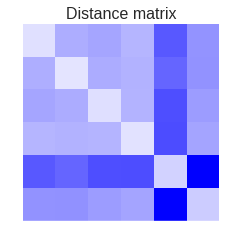

In [29]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(dist[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

# plt.subplot(132)
# plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

# plt.subplot(133)
# plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
# plt.savefig('similarity-generated.png', dpi=120)

In [30]:
from sklearn.manifold.t_sne import TSNE
from sklearn.decomposition import PCA

In [31]:
np.shape(raw_val)

(60, 96, 35)

In [495]:
%%time
pca = PCA(n_components=50)
pca_proj = pca.fit_transform(raw_val)

CPU times: user 716 ms, sys: 0 ns, total: 716 ms
Wall time: 713 ms


In [491]:
# %%time
# dist = pairwise_distances(projection,metric=c2v_score,n_jobs=8) #np.correlate

CPU times: user 160 ms, sys: 92 ms, total: 252 ms
Wall time: 2.54 s


In [32]:
model = TSNE(n_components=2, perplexity=80.0, early_exaggeration=10.0,
             learning_rate=500.0, n_iter=1000,
#              metric=np.correlate,
             metric="precomputed",
             init='random', verbose=1, random_state=1337)

In [33]:
%%time
projection = model.fit_transform(dist) #raw_val

[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Error after 65 iterations with early exaggeration: 42.336857
[t-SNE] Error after 288 iterations: 0.982758
CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 176 ms


In [36]:
_ = scatter(projection,l,n_colors=13)

NameError: name 'l' is not defined

In [35]:
# import matplotlib.patheffects as PathEffects
def scatter(x, colors, n_colors = 10):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_colors))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

#     txts = []
#     for i in range(1,14,1):
#         xtext, ytext = np.median(X[cols == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txts.append(txt)

    return f, ax, sc#, txts

In [37]:
# http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download
# US_stocks = pd.read_csv("/jupyter/data/companylist.csv")
# US_stocks.head()
JP_stocks = pd.read_csv("/jupyter/data/JP Stocks Sector info.csv")
JP_stocks.head()

,日付,Symbol,Company Name,市場・商品区分,33 types code,33業種区分,17 types code,17業種区分,規模コード,規模区分
0,20160428,1301,極洋,市場第一部（内国株）,50,水産・農林業,1,食品,6,TOPIX Small 1
1,20160428,1305,ダイワ上場投信－トピックス,ETF・ETN,-,-,-,-,-,-
2,20160428,1306,ＴＯＰＩＸ連動型上場投資信託,ETF・ETN,-,-,-,-,-,-
3,20160428,1308,上場インデックスファンドＴＯＰＩＸ,ETF・ETN,-,-,-,-,-,-
4,20160428,1309,上海株式指数・上証５０連動型上場投資信託,ETF・ETN,-,-,-,-,-,-


In [55]:
JP_stocks["Symbol"] = JP_stocks.apply(lambda x: str(x[1])+"-T",axis=1)
JP_stocks.head()

,日付,Symbol,Company Name,市場・商品区分,33 types code,33業種区分,17 types code,17業種区分,規模コード,規模区分
0,20160428,1301-T,極洋,市場第一部（内国株）,50,水産・農林業,1,食品,6,TOPIX Small 1
1,20160428,1305-T,ダイワ上場投信－トピックス,ETF・ETN,-,-,-,-,-,-
2,20160428,1306-T,ＴＯＰＩＸ連動型上場投資信託,ETF・ETN,-,-,-,-,-,-
3,20160428,1308-T,上場インデックスファンドＴＯＰＩＸ,ETF・ETN,-,-,-,-,-,-
4,20160428,1309-T,上海株式指数・上証５０連動型上場投資信託,ETF・ETN,-,-,-,-,-,-


In [62]:
# dic = {}
# c = 0
# for s in US_stocks["Sector"]:
#     try:
#         dic[s]
#     except KeyError:
#         dic[s] = c
#         c+=1
# dic

dic = {}
c = 0
for s in JP_stocks["33業種区分"]: #33業種区分  33 types code
    try:
        dic[s]
    except KeyError:
        dic[s] = c
        c+=1
dic

{'-': 1,
 '\xe3\x81\x9d\xe3\x81\xae\xe4\xbb\x96\xe8\xa3\xbd\xe5\x93\x81': 16,
 '\xe3\x81\x9d\xe3\x81\xae\xe4\xbb\x96\xe9\x87\x91\xe8\x9e\x8d\xe6\xa5\xad': 14,
 '\xe3\x82\xac\xe3\x83\xa9\xe3\x82\xb9\xe3\x83\xbb\xe5\x9c\x9f\xe7\x9f\xb3\xe8\xa3\xbd\xe5\x93\x81': 19,
 '\xe3\x82\xb4\xe3\x83\xa0\xe8\xa3\xbd\xe5\x93\x81': 26,
 '\xe3\x82\xb5\xe3\x83\xbc\xe3\x83\x93\xe3\x82\xb9\xe6\xa5\xad': 7,
 '\xe3\x83\x91\xe3\x83\xab\xe3\x83\x97\xe3\x83\xbb\xe7\xb4\x99': 24,
 '\xe4\xb8\x8d\xe5\x8b\x95\xe7\x94\xa3\xe6\xa5\xad': 12,
 '\xe4\xbf\x9d\xe9\x99\xba\xe6\xa5\xad': 29,
 '\xe5\x80\x89\xe5\xba\xab\xe3\x83\xbb\xe9\x81\x8b\xe8\xbc\xb8\xe9\x96\xa2\xe9\x80\xa3\xe6\xa5\xad': 30,
 '\xe5\x8c\x96\xe5\xad\xa6': 23,
 '\xe5\x8c\xbb\xe8\x96\xac\xe5\x93\x81': 11,
 '\xe5\x8d\xb8\xe5\xa3\xb2\xe6\xa5\xad': 2,
 '\xe5\xb0\x8f\xe5\xa3\xb2\xe6\xa5\xad': 15,
 '\xe5\xbb\xba\xe8\xa8\xad\xe6\xa5\xad': 3,
 '\xe6\x83\x85\xe5\xa0\xb1\xe3\x83\xbb\xe9\x80\x9a\xe4\xbf\xa1\xe6\xa5\xad': 9,
 '\xe6\xa9\x9f\xe6\xa2\xb0': 6,
 '\xe6\xb0\x

In [81]:
len(dic.keys())

34

In [76]:
print(dic.keys()[0].decode("utf-8"))

証券、商品先物取引業


In [77]:
_dic = {}
for i in dic:
    _dic[dic[i]] = i

In [79]:
l = []
for idxi,i in enumerate(lab):
    l.append(dic[
            JP_stocks.loc[JP_stocks["Symbol"] == i]["33業種区分"].values[0]
            ])
l = np.array(l)

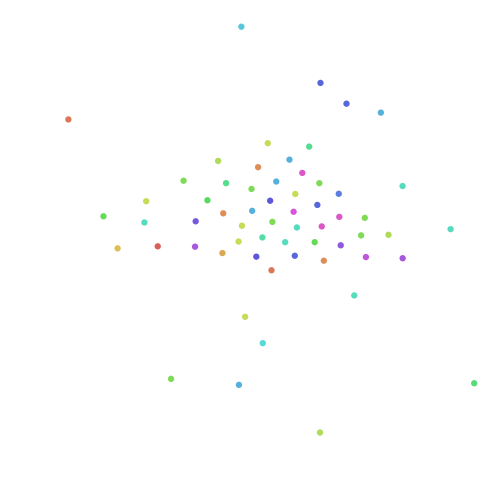

In [82]:
# _ = scatter(projection,pred,n_colors=13)
_ = scatter(projection,l,n_colors=33)

(<matplotlib.figure.Figure at 0x7fbb735f2850>,
 <matplotlib.collections.PathCollection at 0x7fbb733e6c50>)

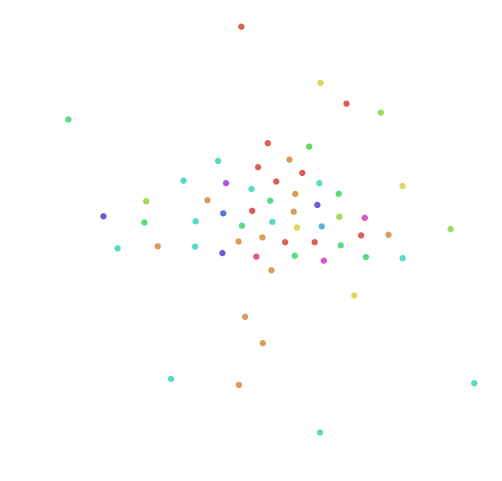

In [83]:
scatter(projection,pred,n_colors=13)

In [86]:
#!pip install plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly as py

# takes ~3s
init_notebook_mode()

Downloading/unpacking plotly
  Running setup.py (path:/tmp/pip_build_root/plotly/setup.py) egg_info for package plotly
    
  Running setup.py install for plotly
    
  Could not find .egg-info directory in install record for plotly
Cleaning up...


In [87]:
trace = go.Scattergl(
    x = projection[:,0],
    y = projection[:,1],
    mode = 'markers',
    marker = dict(
        colorscale = 'Paired',
        color = pred,
#         color = l,
        line = dict(width = 1),
    ),
    text = map(lambda x: x[0]+", "+_dic[x[1]],zip(lab,l)),
)
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=50
#     ),
#     title='RS_opt, threshold high->low = red->white',
#     scene=go.Scene(
#         xaxis=go.XAxis(title='Profit take'),
#         yaxis=go.YAxis(title='Loss cut'),
#     )
# )

In [88]:
fig = go.Figure(data=[trace])#, layout=layout)
iplot(fig)
# !python -c "import plotly; plotly.tools.set_credentials_file(username='m3at', api_key='nbxztisjxm')"
# py.plotly.plot(fig,sharing='public')

In [233]:
dbscan = DBSCAN(eps=0.3, min_samples=10, metric='euclidean',
                algorithm='auto', leaf_size=30, p=None)

In [234]:
pred = dbscan.fit_predict(raw_val)

In [17]:
len(bigvec)

881

In [19]:
len(bigvec[0])

2

In [16]:
print("ok")

ok


In [69]:
import pickle

In [65]:
len(bigvec[0])

3628

In [61]:
bigvec

[['8966-T',
  ('8966-T',
   1.0,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   0.0,
   335000.0,
   446666.66666666663,
   1.0),
  ('9003-T',
   0.8074074074074075,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   2534.7609354730084,
   1960111092.6875,
   3900.0,
   0.88989467375156195),
  ('3223-T',
   0.3851851851851852,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan)],
 ['3223-T',
  ('3223-T',
   1.0,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan),
  ('8966-T',
   0.7428571428571429,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan),
  ('9003-T',
   0.6857142857142857,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan)]]

In [36]:
ret[0]

('8966-T',
 0.8142857142857143,
 Timestamp('2016-05-11 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 2536.1535836774556,
 1963345363.6875,
 33366.666666666664,
 0.90012817395443534)

In [20]:
dff = eod.db

In [21]:
dff["3187-T"].head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-05-08,678,678,665,675,20800
2015-05-11,685,697,674,680,59100
2015-05-12,679,689,671,688,94500
2015-05-13,688,693,670,678,103300
2015-05-14,687,687,647,650,114000


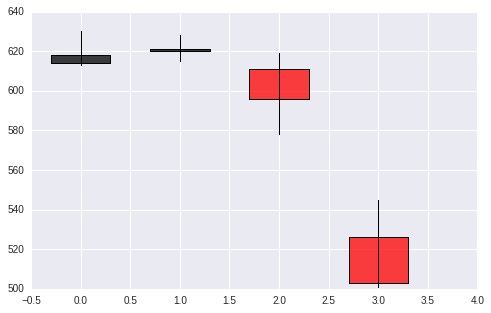

In [22]:
from matplotlib.finance import candlestick2_ohlc

start, end = ret[0][2] , ret[0][3]
x = dff[ret[0][0]][start:end] # np.random.randn(1000)


fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"], x["Close"], width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

In [97]:
from scipy.spatial.distance import cosine, euclidean

In [23]:
all_vec = []
for idxi,i in enumerate(ret[:5]):
    try:
        start, end = i[2] , i[3]
        x = dff[i[0]][start:end] # np.random.randn(1000)
        x["Range"] = x.apply(candle_range, axis=1)
        all_vec.append(x)
    except KeyError:
        pass

In [25]:
ret[1]

('2152-T',
 0.9,
 Timestamp('2016-05-11 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 28.792360097775937,
 64670.25,
 3158.333333333333,
 0.97988641782895436)

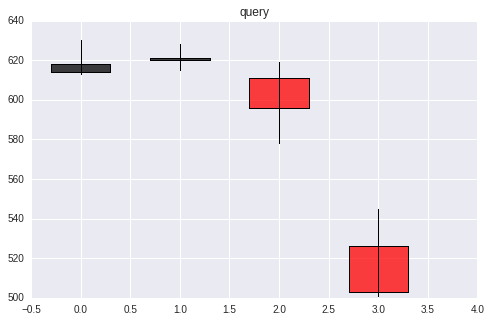

********************************************************************************
RESULTS
********************************************************************************


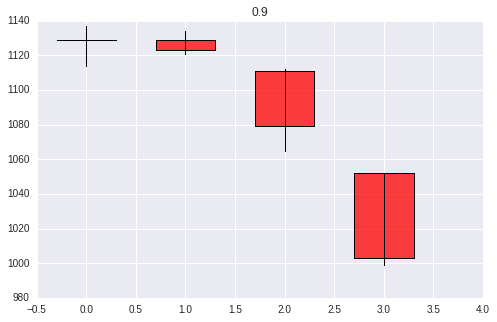

28.7923600978
64670.25
3158.33333333
0.979886417829


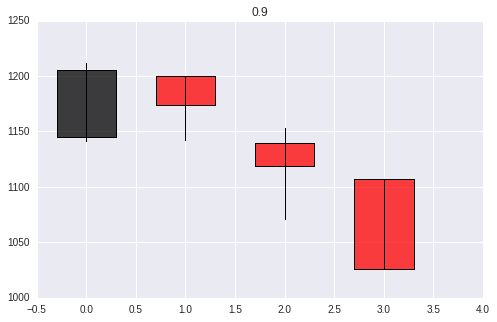

104.9142507
78130.9375
4156.0
0.954342014693


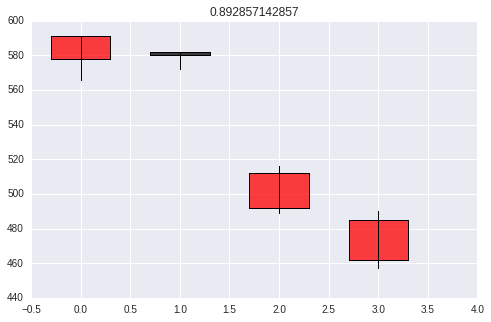

45.7165178026
3321.0
2870.33333333
0.852042604545


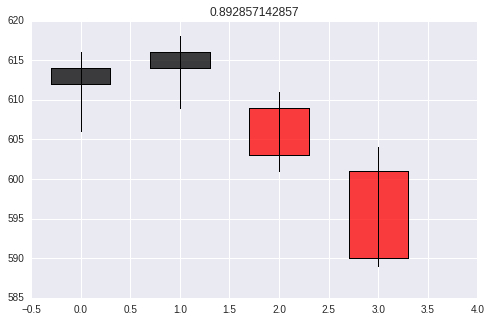

43.2087954009
1320.109375
634.166666667
0.956412571254


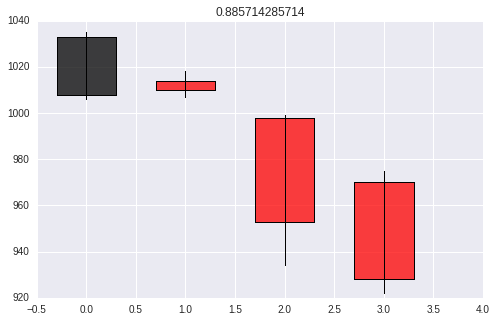

37.1079506306
41348.9375
2266.0
0.83755930035


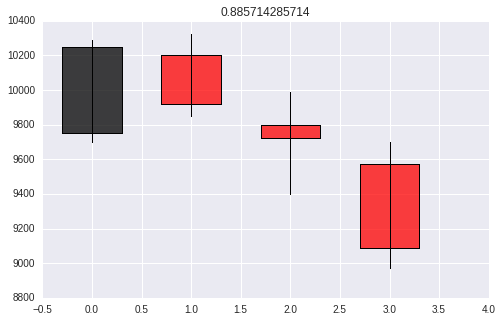

1154.82249718
21069256.1875
25466.6666667
0.940311879988


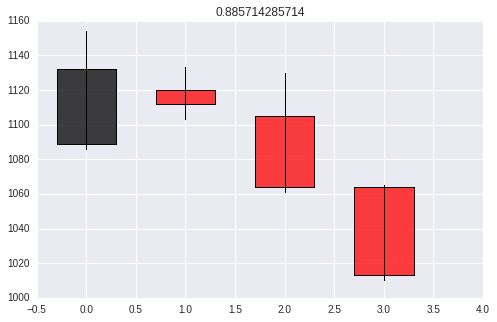

73.1778655059
63654.734375
2728.83333333
0.925782031039


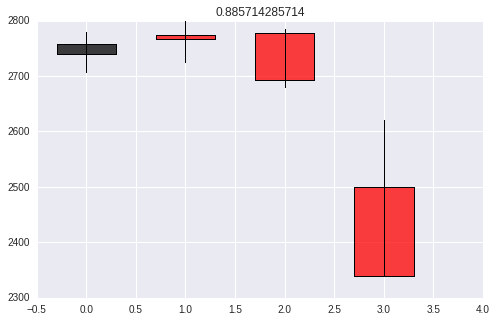

265.037733163
1071978.85938
11203.8333333
0.999202199045


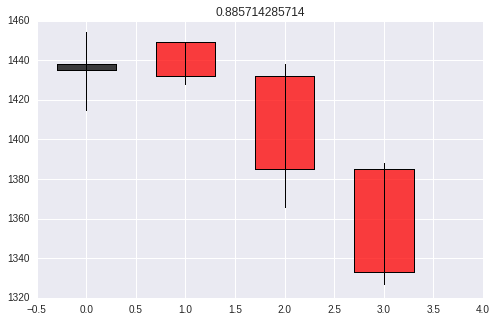

53.7587202229
167085.9375
2576.33333333
0.951731576108


In [26]:
start, end = ret[0][2] , ret[0][3]
x = dff[ret[0][0]][start:end] # np.random.randn(1000)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"], x["Close"], width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()
plt.title("query")
plt.show()

print("*"*80)
print("RESULTS")
print("*"*80)

for idxi,i in enumerate(ret[:10]): # sorted(ret[:10],key=lambda x: x[4])
    if idxi==0:
        continue
    try:
        start, end = i[2] , i[3]
        x = dff[i[0]][start:end] # np.random.randn(1000)
        fig, ax = plt.subplots()
        fig.subplots_adjust(bottom=0.2)
        candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"],
                          x["Close"], width=0.6, colorup='k', colordown='r',
                          alpha=0.75)
        ax.autoscale_view()
        plt.title(i[1])
        plt.show()
        print(i[4])
        print(i[5])
        print(i[6])
        print(i[7])
    except KeyError:
        pass

# 1D Convolution
I simply adapt the kernel size, strides and padding, and input a 2D matrix with one of the dimension=1

In [6]:
import pickle
import numpy as np
from PIL import Image
import os
from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function

import chainer.functions as F
import chainer.links as L


import numpy

In [7]:
nz = 128 #576
mist_val = 16 * 32 # 4 * 512 + 1 * 512
class CNN_1D(chainer.Chain):
    def __init__(self):
        super(CNN_1D, self).__init__(
            c0 = L.Convolution2D(1, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*3)),
            c1 = L.Convolution2D(64, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
            c2 = L.Convolution2D(128, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            # 
            # Max pooling used in a proper way could prevent this but
            # it's adding location invariance, we don't want that
            #
            l4l = L.Linear(mist_val, 1, wscale=0.02*math.sqrt(mist_val)), # 6*6*512
        )
        
    def __call__(self, x, test=False):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        l = self.l4l(h)
# #         mp0 = F.MaxPooling2D(4)
        return l

In [8]:
cnn = CNN_1D()

In [9]:
p = df[:100]["open"].values[:32]

In [10]:
ppp = np.reshape(p,(1,p.shape[0],1))

In [11]:
va = Variable(np.array([ppp.astype(np.float32)]))

In [12]:
ret = cnn(va)

In [13]:
ret.data

array([[ 0.00435226]], dtype=float32)

## Experiments with 1D CNN
Create a simple binary classification dataset

In [14]:
all_open = df["open"].values
len_samples = 32
size_dataset = 1000

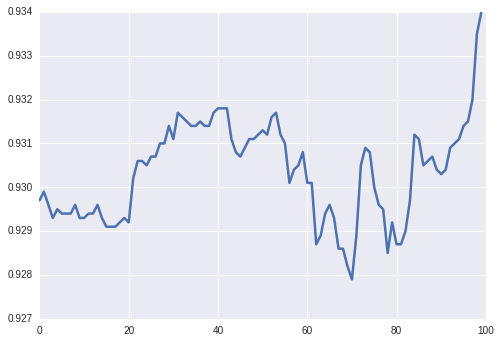

In [15]:
plt.plot(all_open[:100])
plt.show()

In [28]:
# normalisation functions
def norm(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norm(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [17]:
fake_data = np.random.rand(size_dataset/2, len_samples).astype(np.float32)*2 - 1

real_data = np.empty((size_dataset/2, len_samples),dtype=np.float32)
for idxi,i in enumerate(real_data):
    rand = np.random.randint(0,len(all_open)-(len_samples))
    n = center(all_open[rand:rand+len_samples])
    real_data[idxi] = n

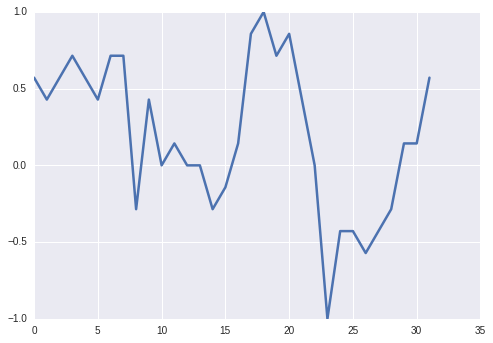

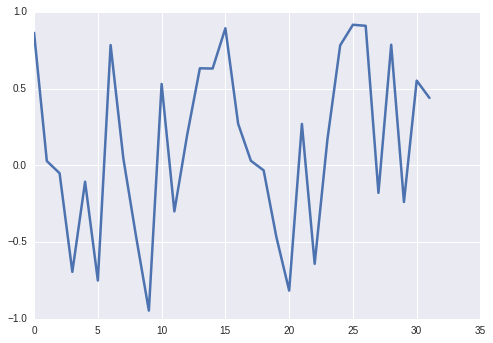

In [516]:
plt.plot(real_data[0])
plt.show()
plt.plot(fake_data[0])
plt.show()

In [18]:
data = zip(np.concatenate((fake_data,real_data)),
           np.concatenate((np.zeros(size_dataset/2).astype(np.int32) - 1,
                           np.ones(size_dataset/2).astype(np.int32)))
          )

In [19]:
data[0]

(array([ 0.27352238,  0.74014652, -0.7279439 ,  0.13564754, -0.59300184,
         0.77416122,  0.31624961, -0.12863523, -0.25189257,  0.7396996 ,
        -0.72045314,  0.87560582,  0.44058502,  0.56000888, -0.18242717,
         0.26759911, -0.40550655,  0.98328996,  0.07490718,  0.31689835,
        -0.06673956, -0.0263719 ,  0.9644928 , -0.60836726, -0.75130033,
         0.29169178, -0.48977178,  0.58678186,  0.11657119, -0.2240659 ,
        -0.58120501, -0.47157347], dtype=float32), -1)

In [20]:
ppp = np.reshape(data[0][0],(1,1,data[0][0].shape[0],1))

In [21]:
output = cnn(Variable(ppp))

In [22]:
output.data

array([[ 0.00191085]], dtype=float32)

In [23]:
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.sigmoid_cross_entropy(y, t) # softmax
        return self.loss

In [24]:
def eval_loss(eval_on=10):
    sum_loss = 0
    for i in range(0, eval_on):
        r_index = np.random.randint(len(data))
        _example,_label = data[r_index][0], data[r_index][1]
        example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
        label = Variable(np.reshape(_label,(1,1)))
        loss = t_cnn( example,label )

        sum_loss += loss.data
    mean_loss = sum_loss / eval_on
    return mean_loss

In [25]:
cnn = CNN_1D()
t_cnn = Train(cnn)
optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [26]:
#%%time
n_epoch = 100

for epoch in range(n_epoch):
    cnn.zerograds()
    
    r_index = np.random.randint(len(data))
    _example,_label = data[r_index][0], data[r_index][1]
    example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
    label = Variable(np.reshape(_label,(1,1)))
#     t_cnn( Variable(ppp),Variable(np.reshape(label,(1,1)) ))
    
    optimizer.update(t_cnn,example,label)
    
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),eval_loss()))

0         : 0.207490945
5         : 0.196202570
10        : 0.382884312
15        : 0.272359699
20        : 0.241174093
25        : 0.133280491
30        : 0.006006680
35        : 0.000066515
40        : 0.000000069
45        : 0.000000002
50        : 0.000000000
55        : 0.000000000
60        : 0.000000000
65        : 0.000000000
70        : 0.000000000
75        : 0.000000000
80        : 0.000000000
85        : 0.000000000
90        : 0.000000000
95        : 0.000000000
99        : 0.000000000


6.26358634016e-19 1 ok


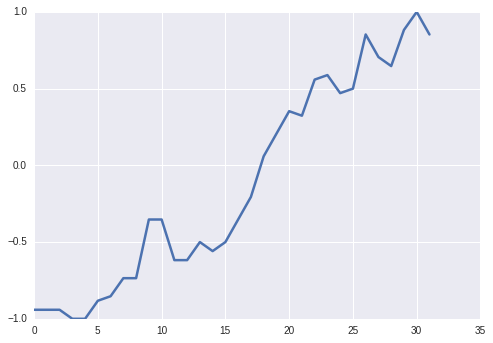

In [29]:
r_index = np.random.randint(len(data))
_example,_label = data[r_index][0], data[r_index][1]
example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
label = Variable(np.reshape(_label,(1,1)))
loss = t_cnn( example,label )

print(loss.data,_label, "ok" if (loss.data>0 and _label==1) or (loss.data<=0 and _label==-1) else "FALSE")
plt.plot(_example)
plt.show()

In [30]:
print("Loss:",eval_loss(eval_on=1000))

Loss: 2.28441817157e-11


---

---

---

---

---

---

In [7]:
class Generator(chainer.Chain):
    def __init__(self):
        super(Generator, self).__init__(
            l0z = L.Linear(nz, mist_val, wscale=0.02*math.sqrt(nz)),
            dc1 = L.Deconvolution2D(nz, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*512)),
            dc2 = L.Deconvolution2D(256, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*256)),
            dc3 = L.Deconvolution2D(128, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            dc4 = L.Deconvolution2D(64, 3, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
        )
    def __call__(self, z, test=False):
        h = F.reshape(F.relu(self.l0z(z)), (z.data.shape[0], 128, 4, 1)) # 512, 6, 6))
        h = F.relu(self.dc1(h))
        h = F.relu(self.dc2(h))
        h = F.relu(self.dc3(h))
        x = (self.dc4(h))
        return x

class Discriminator(chainer.Chain):
    def __init__(self):
        super(Discriminator, self).__init__(
            c0 = L.Convolution2D(1, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*3)),
            c1 = L.Convolution2D(64, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
            c2 = L.Convolution2D(128, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            l4l = L.Linear(mist_val, 2, wscale=0.02*math.sqrt(mist_val)), # 6*6*512
        ) 
    def __call__(self, x, test=False):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        l = self.l4l(h)
        return l

In [256]:
g = Generator()

In [50]:
out = g(Variable(np.array([np.random.randn(nz).astype(np.float32)])))

NameError: name 'g' is not defined

In [259]:
out.data[0][0]

array([[-0.00132109],
       [-0.00762908],
       [-0.00277361],
       [-0.01768656],
       [ 0.0030693 ],
       [-0.01951565],
       [ 0.00167972],
       [-0.02423818],
       [ 0.00691997],
       [-0.01482223],
       [-0.01639871],
       [-0.01389591],
       [-0.01467269],
       [-0.03430352],
       [-0.01828811],
       [-0.01573746],
       [-0.01368324],
       [-0.02861563],
       [-0.00709159],
       [-0.04232799],
       [-0.02057808],
       [-0.01282598],
       [-0.01741303],
       [-0.03164081],
       [-0.02795931],
       [-0.01647522],
       [-0.01239936],
       [-0.03419115],
       [-0.00689191],
       [-0.02075935],
       [-0.00333366],
       [-0.03502258],
       [-0.020837  ],
       [-0.02870523],
       [-0.0280411 ],
       [-0.04126644],
       [ 0.00832296],
       [-0.00737745],
       [-0.0342315 ],
       [-0.04325666],
       [-0.00829059],
       [-0.02737384],
       [-0.00743409],
       [-0.02975341],
       [-0.01572187],
       [-0

In [277]:
all_val = df["open"].values

In [687]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [476]:
from chainer import function
from chainer.utils import type_check


class MeanError(function.Function):

    """Mean squared error (a.k.a. Euclidean loss) function."""

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 2)
        type_check.expect(
            in_types[0].dtype == numpy.float32,
            in_types[1].dtype == numpy.float32,
            in_types[0].shape == in_types[1].shape
        )

    def forward_cpu(self, inputs):
        x0, x1 = inputs
        self.diff = x0 - x1
        diff = self.diff.ravel()
        return numpy.array(diff.dot(diff) / diff.size, dtype=diff.dtype),

    def forward_gpu(self, inputs):
        x0, x1 = inputs
        self.diff = x0 - x1
        diff = self.diff.ravel()
        return diff.dot(diff) / diff.dtype.type(diff.size),

    def backward(self, inputs, gy):
        coeff = gy[0] * gy[0].dtype.type(2. / self.diff.size)
        gx0 = coeff * self.diff
        return gx0, -gx0


def mean_error(x0, x1):
    """Mean squared error function.

    This function computes mean squared error between two variables. The mean
    is taken over the minibatch. Note that the error is not scaled by 1/2.

    """
    return MeanError()(x0, x1)

In [956]:
in_size = 100
h_size = 25
h_size2 = 50
# h_size3 = 600

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.Linear(h_size2,h_size),
            l3 = L.Linear(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.Linear(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.sigmoid(self.l0(x))
#         h = F.sigmoid(self.l1(h))
#         h = F.sigmoid(self.l2(h))
#         h = F.sigmoid(self.l3(h))
#         h = F.sigmoid(self.l4(h))
#         h = F.sigmoid(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = mean_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

class Train_contrastive(chainer.Chain):
    def __init__(self, predictor):
        super(Train_contrastive, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
#         print(np.shape(y.data))
#         label = np.zeros(np.shape(y.data)[0])
        
#         for idxi,i in enumerate(y.data):
#             eq = True
#             for idxj,j in enumerate(i):
# #                 if y.data[idxi, idxj] == t.data[idxi, idxj]:
# #                     label[idxi, idxj] = 1
#                 if y.data[idxi, idxj] != t.data[idxi, idxj]:
#                     eq = False
#             if eq:
#                 label[idxi] = 1
        
        self.loss = F.mean_squared_error(y, t)
#         self.loss = F.contrastive(y, t, Variable(label.astype(np.int32)))
#         self.loss = F.cross_covariance(y, t)*0.0001 + F.mean_squared_error(y, t)
#         self.loss = F.mean_squared_error(y, t)
        return self.loss

In [957]:
ae = AutoEnc()
tae = Train_contrastive(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [959]:
#%%time
n_epoch = 1000
batch_size = 100

for epoch in range(n_epoch):
    ba = []
    ba2 = []
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size))
#         inp = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
        inp = norm_and_center(all_val[ma:ma+in_size+1])
        ba.append(inp.astype(np.float32))

    
    v = Variable(cuda.to_gpu(np.array(ba)))
#     v_out = Variable(cuda.to_gpu(np.array(ba2)))
#     v = Variable(np.array(ba))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.079519711
100       : 0.078348659
200       : 0.081630409
300       : 0.081015773
400       : 0.078227736
500       : 0.081589282
600       : 0.079601988
700       : 0.080021054
800       : 0.080190599
900       : 0.079753555
1000      : 0.081974924
1100      : 0.077046268
1200      : 0.080480106
1300      : 0.077491365
1400      : 0.079150856
1500      : 0.076476730
1600      : 0.083291396
1700      : 0.078388669
1800      : 0.078637674
1900      : 0.076469719
1999      : 0.076323636


[ 0.14613178  0.09727522 -0.24473497  0.9399367   0.28046814 -0.04924997
  0.90308452 -0.72065198  0.42704511  0.18276991]
[ 0.24341851  0.31210545  0.08918103  0.33857918  0.26868463 -0.11299844
  0.58684075 -0.29261008  0.71104687 -0.02799233]


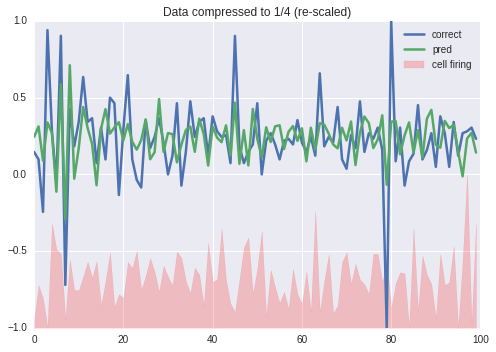

(Higher is better)
Inv. covariance:   269.011142827
Inv. correlation:  0.133885


In [1135]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# inp2 = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))
# v = Variable(np.array([inp.astype(np.float32)]))


ret = ae(v)

print(inp[:10])
print(ret.data[0][:10])

su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),(center(su)+1)/2 -1,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()


x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

In [1013]:
ae.l0(v).data[0]

array([ 0.09046914,  0.06891366,  0.18637428,  0.03789999,  0.32173747,
       -0.16829924, -0.19929126,  0.13154386,  0.49780136,  0.54685652,
        0.10964749,  0.13242628, -0.10634674,  0.23858622, -0.42236158,
        0.34668338, -0.01765037, -0.23904039,  0.19271323, -0.06891738,
       -0.44082975,  0.05053517,  0.24479896,  0.15586013, -0.03582393,
       -0.1414412 , -0.0392537 ,  0.19534455,  0.1980195 ,  0.01748553,
       -0.14061546, -0.1146475 , -0.19260731, -0.08392124, -0.00226129,
       -0.06934342, -0.38787735, -0.26715416,  0.03045877, -0.00888004,
       -0.00157548,  0.04113426, -0.04155827, -0.06009218,  0.31067041,
       -0.06400891, -0.26977402, -0.02321906,  0.43902707,  0.04194541], dtype=float32)

In [1012]:
su

array([-0.76344997, -0.12239879, -0.3743214 , -0.91069198,  1.02260554,
        0.54596758,  0.46850577, -0.76191646,  0.35370865, -0.21014595,
       -0.22101504,  0.04053895,  0.31444529,  0.01296253,  0.32189378,
       -0.50228518, -0.04563873,  0.48079956, -0.53426927, -0.29273874,
       -0.35871208,  0.31033736,  0.19483574,  0.51602322, -0.2143192 ,
        0.0530674 ,  0.38084313,  0.12206851, -0.24826474,  0.23616631,
        0.03401733, -0.13206199,  0.50632966,  0.38490397, -0.05212657,
       -0.27169567,  0.20356125,  0.07264572, -0.5038507 ,  0.66516221,
       -0.06230236, -0.01107755,  0.93286228, -0.03270606, -0.46880949,
       -0.62574428, -0.0185521 ,  0.58606142,  0.76730323, -0.28324708,
        0.18205348,  0.88391691, -0.71182036,  0.15870056, -0.16535906,
       -0.45628813, -0.25119033, -0.56723499,  0.17572922, -0.29514197,
       -0.4787963 ,  0.12560385, -0.61803418,  1.25860703, -0.62739921,
       -0.04622063,  0.44917187, -0.64959514, -0.50008661,  0.30

In [1137]:
a = np.array([1,2,3])

In [1138]:
np.repeat(a,2)

array([1, 1, 2, 2, 3, 3])

In [1062]:
g = ae.links()

In [1077]:
t = []
for i in ae.namedlinks():
    print(i)
    if len(i[0])>1:
        t.append(i)

('/', <__main__.AutoEnc object at 0x7f12c2e02b50>)
('/l5', <chainer.links.connection.linear.Linear object at 0x7f12c2e6d050>)
('/l2', <chainer.links.connection.linear.Linear object at 0x7f12c3ac4210>)
('/l3', <chainer.links.connection.linear.Linear object at 0x7f12c2e21610>)
('/l0', <chainer.links.connection.linear.Linear object at 0x7f12c2e21410>)


In [1078]:
t.sort(key=lambda x: x[0])
t

[('/l0', <chainer.links.connection.linear.Linear at 0x7f12c2e21410>),
 ('/l2', <chainer.links.connection.linear.Linear at 0x7f12c3ac4210>),
 ('/l3', <chainer.links.connection.linear.Linear at 0x7f12c2e21610>),
 ('/l5', <chainer.links.connection.linear.Linear at 0x7f12c2e6d050>)]

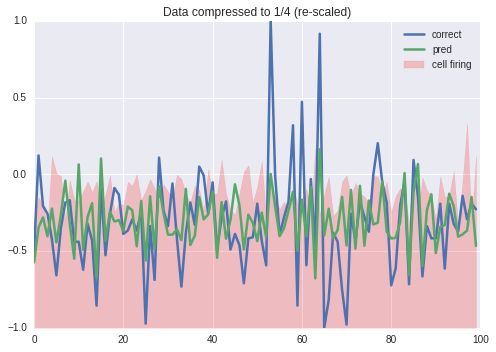

In [1153]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ret = ae(v)




# x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

# xx = map(lambda x: [x[0],x[1].tolist()], x)

# cova = np.cov(xx)
# # print(cova[0][1])
# print("(Higher is better)")
# print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
# print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))
    
    
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),center(su)/3,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()

In [1141]:
100/link.W.data.shape[0]

2

In [1144]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))

In [1083]:
len(ae.l0(v).data[0])

50

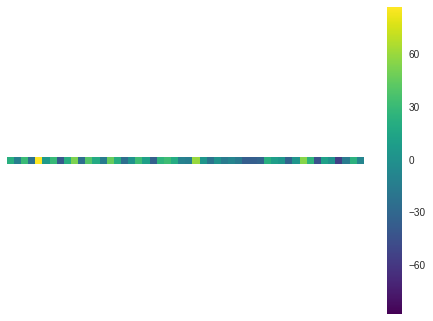

In [1125]:
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)
sns.heatmap([cuda.to_cpu(ae.l0(v).data)[0]],
            cmap="viridis",
            square=True,
            xticklabels=False,
            yticklabels=False,
)
# sns.heatmap([su]).set(xticks=[],yticks=[])
plt.show()

In [859]:
in_size = 1000
h_size = 250
h_size2 = 400
h_size3 = 700

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.LSTM(h_size2,h_size),
            l3 = L.LSTM(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.LSTM(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def reset_state(self):
        self.l2.reset_state()
        self.l3.reset_state()
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.tanh(self.l0(x))
#         h = F.tanh(self.l1(h))
#         h = F.tanh(self.l2(h))
#         h = F.tanh(self.l3(h))
#         h = F.tanh(self.l4(h))
#         h = F.tanh(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

In [860]:
L.LSTM

chainer.links.connection.lstm.LSTM

In [862]:
ae = AutoEnc()
tae = Train(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [863]:
ae.reset_state()

In [915]:
#%%time
n_epoch = 10000
batch_size = 100

ae.reset_state()


for epoch in range(n_epoch):
#     ba = []
#     for i in range(batch_size):
#         ma = np.random.randint(0,len(all_val)-(in_size+1))
#         inp = norm_and_center(all_val[ma:ma+in_size+1])   
#         ba.append(inp.astype(np.float32))

    ae.reset_state()

    ma = np.random.randint(0,len(all_val)-(in_size+1))
    inp = norm_and_center(all_val[ma:ma+in_size+1]) 
    ba = np.array([[i] for i in inp]).astype(np.float32).T
    
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.034014281
500       : 0.059305616
1000      : 0.017694764
1500      : 0.024822626
2000      : 0.055266380
2500      : 0.004791535
3000      : 0.019841157
3500      : 0.028654182
4000      : 0.027645271
4500      : 0.030106673
5000      : 0.030367998
5500      : 0.039066449
6000      : 0.030299069
6500      : 0.042325731
7000      : 0.036139227
7500      : 0.020557543
8000      : 0.031770591
8500      : 0.021898065
9000      : 0.002638343
9500      : 0.034405995
9999      : 0.038353320


[-0.15666932 -0.15667267 -0.20088819 -0.06824835  0.02015255 -0.06826174
 -0.06826508  0.02010237 -0.20084134 -0.20085472]
[-0.11258598 -0.1085121  -0.12179309 -0.10832338 -0.13369234 -0.14219289
 -0.13632657 -0.1349892  -0.13737531 -0.14978775]
(Higher is better)
Inv. covariance:   38.0815700497
Inv. correlation:  0.0741957


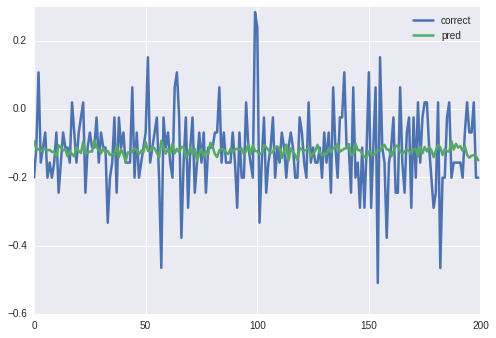

In [926]:
ae.reset_state()
# ma = np.random.randint(0,len(all_val)-(in_size+1))
# inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ma = np.random.randint(0,len(all_val)-(in_size+1))
inp = norm_and_center(all_val[ma:ma+in_size+1]) 
ba = np.array([[i] for i in inp]).astype(np.float32).T

v = Variable(cuda.to_gpu(np.array(ba)))

ret = ae(v)

print(inp[-10:])
print(ret.data[0][-10:])

plt.plot(inp[-200:],label="correct")
plt.plot(cuda.to_cpu(ret.data)[0][-200:],label="pred")
plt.legend()
x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

In [349]:
sum_loss, sum_accuracy = 0, 0

for i in range(0, 1000, batch_size):
    ba=[]
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size+1))
        inp = norm_and_center(all_val[ma:ma+(in_size+1)])
        ba.append(inp.astype(np.float32))
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    loss = tae(v, v)
    sum_loss += loss.data * batch_size
mean_loss = sum_loss / 1000
print(mean_loss)

0.0370470620692


In [8]:
from __future__ import print_function
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

mp = load_json("/project/exp/list_mp.json")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

In [ ]:
#!cat /project/python/lib/ml/simsearch.py

In [9]:
%%time
# %%time
# %%timeit -n 20
# "201402041452","start":"201402041332
start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"
ret = search(mp,start,end, samples=10000, k_nearest=5)

CPU times: user 40 ms, sys: 88 ms, total: 128 ms
Wall time: 292 ms


In [10]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([[[i]] for i in c]).astype(np.float32)
#cc = norm_and_center(seq[11]["open"].values)

---

In [17]:
df[start:end]["open"].values

array([ 1.1393 ,  1.13912,  1.13902,  1.13896,  1.13862,  1.1384 ,
        1.13846,  1.13834,  1.13822,  1.13814,  1.13808,  1.138  ,
        1.13804,  1.13813,  1.13811,  1.13816,  1.13799,  1.13761,
        1.13739,  1.13729,  1.13769,  1.13788,  1.13787,  1.13776,
        1.13789,  1.13785,  1.1381 ,  1.13838,  1.13809,  1.13807,
        1.13804,  1.13771,  1.13759,  1.13795,  1.13814,  1.13818,
        1.13796,  1.13775,  1.13801,  1.13802,  1.13764,  1.13768,
        1.13767,  1.13751,  1.13744])

In [22]:
ddf = df[start:end]

In [14]:
ddf.head()

,open,high,low,close
2015-01-09 00:00:00+00:00,1.17922,1.17938,1.17906,1.17926
2015-01-09 00:05:00+00:00,1.17924,1.17945,1.17924,1.17940
2015-01-09 00:10:00+00:00,1.17939,1.17942,1.17926,1.17933
2015-01-09 00:15:00+00:00,1.17933,1.17935,1.17924,1.17924
2015-01-09 00:20:00+00:00,1.17926,1.17926,1.17909,1.17911


In [103]:
def norma(seq):
    return map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:]))
def norm_and_center(x,scale=1):
    c2 = np.array(norma(x))
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return [i for i in c]

In [104]:
dd = ddf.apply(norm_and_center, axis=0, reduce=True,raw=True)
np.shape(dd)

(4,)

In [105]:
type(dd[0])

list

In [106]:
dd.apply(pd.Series).T.head()

,open,high,low,close
0,0.142759,0.056373,0.348208,0.288967
1,0.338427,-0.084607,0.110934,-0.022438
2,0.022342,-0.141001,0.051617,-0.052103
3,0.007285,-0.169205,-0.141168,-0.111437
4,-0.098094,0.028185,0.096107,0.244505


In [35]:
np.shape(ddf)

(109, 4)

In [23]:
dd = pd.DataFrame(columns=["open"])
dd["open"] = norma(ddf["open"].values)
dd

,open
0,0.000017
1,0.000127
2,-0.000051
3,-0.000059
4,-0.000119
5,0.000085
6,-0.000008
7,0.000170
8,-0.000076
9,0.000187


In [8]:
#%%time
start, end = "2015-01-9 00:00:00+0000" , "2015-01-9 09:00:00+0000"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"  2015-01-10 00:00:00+0000
ret = search(mp,start,end, samples=10000, k_nearest=5)

QUERY


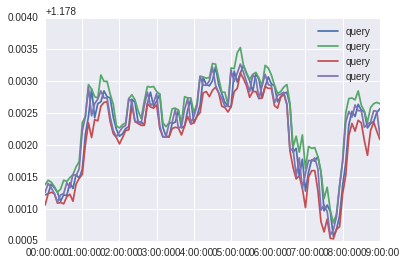

SUGGESTIONS


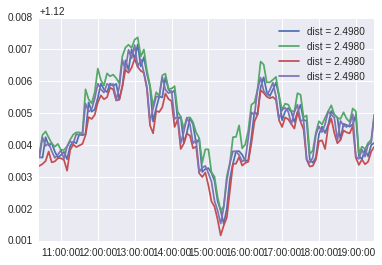

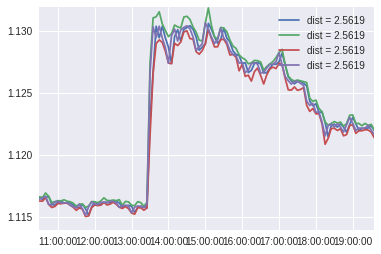

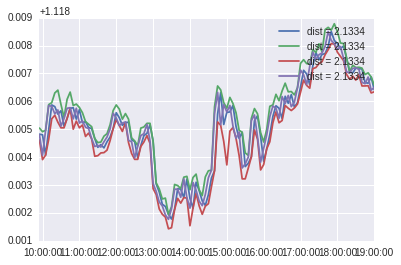

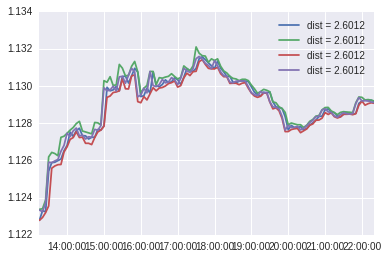

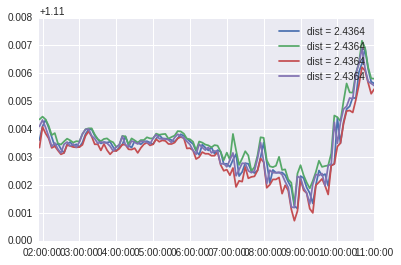

In [9]:
print("QUERY")
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()
print("SUGGESTIONS")
for n in range(len(ret)):
    plt.plot(df[ret[n]["start"]:ret[n]["end"]],label="dist = %.04f"%(ret[n]["distance"]))
    plt.legend()
    plt.show()
    
# print("*"*80)
